In [99]:
# Import common libraries
import pandas as pd
import numpy as np
from copy import deepcopy
import importlib


# Import MNE processing
from mne.viz import plot_compare_evokeds
from mne import Epochs, events_from_annotations, set_log_level

# Scikit Learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Internal Packages
import analysis_tools
import system_file_io

# Reset the cache
importlib.reload(analysis_tools)


<module 'analysis_tools' from '/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py'>

## Notes for Future Features

In [100]:
# TODO: Allowing for custom timestamps to be imported

"""
Apparently the way to do this is: 
    events = np.array([[sample, 0, event_id, timestamp], ...])
where:
    sample: the sample number of the event in the data. This is the position in the data where the event occurs.
    0: this column is usually used as a reserved column in MNE functions, it's not used in this case.
    event_id: an integer that identifies the type of event. This can be used to distinguish different types of triggers, for example, different stimulus conditions, button presses, or other experimental events.
    timestamp: the time in seconds of the event.
"""

"\nApparently the way to do this is: \n    events = np.array([[sample, 0, event_id, timestamp], ...])\nwhere:\n    sample: the sample number of the event in the data. This is the position in the data where the event occurs.\n    0: this column is usually used as a reserved column in MNE functions, it's not used in this case.\n    event_id: an integer that identifies the type of event. This can be used to distinguish different types of triggers, for example, different stimulus conditions, button presses, or other experimental events.\n    timestamp: the time in seconds of the event.\n"

In [101]:
# Tip for using machine learning for exploratory type data analysis

# Use principal component analysis (PCA) or independent component analysis (ICA), 
# to identify patterns in the fNIRS data that are not immediately obvious. 
# This can be used to identify latent neural networks or to identify different sources of signal variation.

# ==========================================================

# I'm curious how we could incorportate these into the data analsyis pipeline

# Anomaly detection
# Unsupervised learning algorithms such as one-class SVM, Autoencoder, and Isolation Forest can be used to identify outliers or abnormal patterns in the data.

# Time-series analysis
# Techniques such as time-series decomposition, ARIMA, and LSTM can be used to analyze the temporal dynamics of the fNIRS data and identify trends or patterns over time.

In [102]:
# Recurring values that we will keep the same

# Length of the measured interval
interval_length = 15

# How you would like to rename the numeric triggers from Aurora
trigger_id = {'4': 'Control', '2': 'Neutral', '3': 'Inflammatory', '1':'Practice'}

# What files would you like to ignore while looping through subjects
ignore = [".DS_Store", "sub-03"]

# File path to the folder containing the BIDS data.
root_dir = '../../LabResearch/IndependentStudy/DataAnalysis'

# Mock data folder to test pulling meta data from folder structure.
path = "../../LabResearch/IndependentStudy/Data"


# Find Groups and Subjects from Folder Structure

In [103]:
importlib.reload(system_file_io)

groups, df = system_file_io.import_data_folder(path, ignore)
df

,group,sub_name,snirf_path
0,anon,sub-06,../../LabResearch/IndependentStudy/Data/anon/s...
1,anon,sub-07,../../LabResearch/IndependentStudy/Data/anon/s...
2,anon,sub-05,../../LabResearch/IndependentStudy/Data/anon/s...
3,direct,sub-01,../../LabResearch/IndependentStudy/Data/direct...
4,direct,sub-02,../../LabResearch/IndependentStudy/Data/direct...
5,direct,sub-04,../../LabResearch/IndependentStudy/Data/direct...


# Loop through subjects for individual analysis

In [104]:
group = 'direct'
paths = df[df.eq(group).any(1)]['snirf_path'].to_numpy()
print(paths)

['../../LabResearch/IndependentStudy/Data/direct/sub-01/nirs/sub-01_task-AnonCom_nirs.snirf'
 '../../LabResearch/IndependentStudy/Data/direct/sub-02/nirs/sub-02_task-AnonCom_nirs.snirf'
 '../../LabResearch/IndependentStudy/Data/direct/sub-04/nirs/sub-04_task-AnonCom_nirs.snirf']


In [105]:
all_epochs = analysis_tools.aggregate_epochs(paths=paths, trigger_id=trigger_id)

all_epochs

Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../LabResearch/IndependentStudy/Data/direct/sub-01/nirs/sub-01_task-AnonCom_nirs.snirf
Reading 0 ... 17097  =      0.000 ...  1680.635 secs...
[[ 196    0    1]
 [ 221    0    1]
 [ 250    0    1]
 [ 263    0    1]
 [ 289    0    1]
 [ 316    0    1]
 [ 366    0    4]
 [ 414    0    4]
 [ 454    0    4]
 [ 502    0    4]
 [ 542    0    4]
 [ 590    0    4]
 [ 705    0    3]
 [ 753    0    3]
 [ 782    0    3]
 [ 830    0    3]
 [ 861    0    3]
 [ 909    0    3]
 [1010    0    2]
 [1058    0    2]
 [1091    0    2]
 [1139    0    2]
 [1173    0    2]
 [1221    0    2]]
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../LabResearch/IndependentStudy/Data/direct/sub-02/nirs/sub-02_task-AnonCom_nirs.snirf
Reading 0 ... 14803  =      0.000 ...  1455.135 secs...
[[ 138    0    1]
 [ 162    0    1]
 [ 190    0    1]
 [ 215    0    1]
 [ 255    0    1]
 [ 288    0    1]
 [ 331    0    4]
 [ 379    0    4]
 [ 419   

defaultdict(list,
            {'Control': [<Epochs |  3 events (all good), -1.25 - 15 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
               'Control': 3>,
              <Epochs |  3 events (all good), -1.25 - 15 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
               'Control': 3>,
              <Epochs |  3 events (all good), -1.25 - 15 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
               'Control': 3>],
             'Inflammatory': [<Epochs |  3 events (all good), -1.25 - 15 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
               'Inflammatory': 3>,
              <Epochs |  3 events (all good), -1.25 - 15 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
               'Inflammatory': 3>,
              <Epochs |  3 events (all good), -1.25 - 15 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
               'Inflammatory': 3>],
             'Neutral': [<Epochs |  3 events (all good), -1.25 - 15 sec, baseline -1.25 – 0 sec, ~171 kB, data

# Extract Evoked Amplitude


In [106]:
tmin=-1
tmax=15

In [107]:

df = analysis_tools.extract_average_amplitudes(all_epochs, tmin, tmax)
df

,ID,Chroma,Condition,Value
0,1,hbo,Control,3.483155
1,1,hbr,Control,-1.469457
2,2,hbo,Control,-3.349150
3,2,hbr,Control,1.302312
4,3,hbo,Control,-1.383540
5,3,hbr,Control,0.659693
6,1,hbo,Inflammatory,7.303865
7,1,hbr,Inflammatory,-2.519865
8,2,hbo,Inflammatory,-0.559046
9,2,hbr,Inflammatory,0.337647


In [108]:
# Returns all measurements taken with each column being a sample taking at a certain time and the rows are a participant hbo or hbr.
amplitudes = analysis_tools.extract_all_amplitudes(all_epochs, tmin, tmax)
amplitudes

,0,1,2,3,4,5,6,7,8,9,...,242,243,244,245,246,247,248,249,250,251
0,-1.913069,1.913069,12.194573,13.563232,15.862768,28.925506,39.406275,28.697911,20.048427,19.550039,...,-10.346175,-6.468071,-4.515513,-3.144053,-2.104607,-0.540207,0.198986,7.126587,17.030881,20.074499
1,1.394451,-1.394451,-8.888720,-9.886347,-11.562496,-21.084028,-28.723543,-20.918132,-14.613456,-14.250177,...,4.013481,2.509089,1.751654,1.219639,0.816418,0.209557,-0.077191,-2.764540,-6.606607,-7.787285
2,3.631319,-3.631319,-5.557568,-10.771924,-14.779576,-13.123955,-15.263019,-14.445252,-9.562802,-5.169188,...,-0.465418,2.135859,2.618055,7.989943,13.772362,13.520064,7.318763,1.361247,0.607034,-5.413153
3,-1.575737,1.575737,2.411593,4.674257,6.413296,5.694873,6.623076,6.268223,4.149583,2.243064,...,0.203451,-0.933660,-1.144445,-3.492688,-6.020389,-5.910101,-3.199292,-0.595049,-0.265356,2.366282
4,-0.680507,0.680507,6.368110,7.282208,8.288017,10.683752,8.469412,5.333772,3.222518,0.641667,...,2.276514,2.415489,0.345953,-1.047083,-1.313143,-2.892978,-3.726293,-4.500490,-5.424266,-3.870961
5,0.399926,-0.399926,-3.742462,-4.279667,-4.870769,-6.278713,-4.977372,-3.134594,-1.893836,-0.377100,...,-1.379426,-1.463636,-0.209626,0.634467,0.795683,1.752965,2.257902,2.727017,3.286768,2.345562
6,5.817229,-5.817229,-6.413682,21.727665,28.974493,23.125846,15.190498,14.122766,18.724844,15.065900,...,1.406290,3.745767,3.277944,11.729411,19.535390,15.755637,16.015232,15.619648,13.449667,10.660944
7,-4.240224,4.240224,4.674983,-15.837465,-21.119736,-16.856611,-11.072473,-10.294195,-13.648686,-10.981653,...,-0.545527,-1.453055,-1.271578,-4.550064,-7.578154,-6.111915,-6.212617,-6.059162,-5.217385,-4.135586
8,-1.832878,1.832878,8.382801,5.739572,3.208490,3.972800,4.153758,3.640773,2.444532,2.411488,...,40.531030,43.180263,40.834393,26.448187,27.303608,21.441002,9.830792,3.807765,-3.998894,-11.544535
9,0.795340,-0.795340,-3.637545,-2.490570,-1.392259,-1.723916,-1.802438,-1.579839,-1.060755,-1.046416,...,-17.717554,-18.875628,-17.850165,-11.561443,-11.935378,-9.372624,-4.297389,-1.664509,1.748059,5.046526


# Use PCA in order to reduce the number of points in the temporal readings

## To do
- figure out if PCA is effective for the dataset or not
- Does the dataset need to be scaled (or should it normalized)
- Why are HBO and HBR the same value?

In [109]:
# scaler = StandardScaler()
# measurements_df = scaler.fit_transform(measurements_df)
# measurements_df = pd.DataFrame(measurements_df)

pca = PCA(n_components=1)

reduced_measurements = pca.fit_transform(amplitudes)

df['ReducedValue'] = reduced_measurements

df


,ID,Chroma,Condition,Value,ReducedValue
0,1,hbo,Control,3.483155,85.346967
1,1,hbr,Control,-1.469457,-58.028111
2,2,hbo,Control,-3.349150,-34.524524
3,2,hbr,Control,1.302312,-3.141575
4,3,hbo,Control,-1.383540,-38.918319
5,3,hbr,Control,0.659693,6.096993
6,1,hbo,Inflammatory,7.303865,239.093230
7,1,hbr,Inflammatory,-2.519865,-122.993447
8,2,hbo,Inflammatory,-0.559046,-10.023737
9,2,hbr,Inflammatory,0.337647,-9.635313


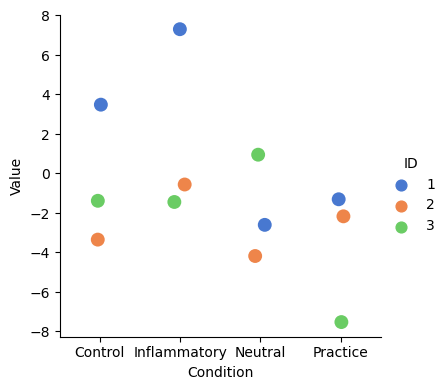

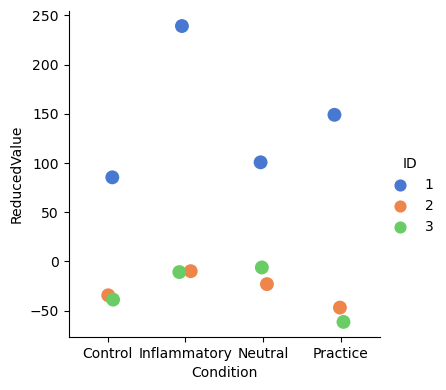

In [110]:
# Plot the Data
sns.catplot(x="Condition", y="Value", hue="ID", data=df.query("Chroma == 'hbo'"), ci=None, palette="muted", height=4, s=10)
plt.show()

# Plot the Data
sns.catplot(x="Condition", y="ReducedValue", hue="ID", data=df.query("Chroma == 'hbo'"), ci=None, palette="muted", height=4, s=10)
plt.show()

In [111]:
# Inflammatory vs Neutral Prompt Analysis

input_data = df.query("Condition in ['Neutral', 'Inflammatory']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("ReducedValue ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                MixedLM    Dependent Variable:    ReducedValue
No. Observations:     6          Method:                REML        
No. Groups:           3          Scale:                 3043.0857   
Min. group size:      2          Log-Likelihood:        -24.8039    
Max. group size:      2          Converged:             Yes         
Mean group size:      2.0                                           
--------------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
--------------------------------------------------------------------
Intercept              72.713   64.894  1.121 0.262  -54.476 199.903
Condition[T.Neutral]  -48.989   45.041 -1.088 0.277 -137.268  39.291
Group Var            9590.450  284.867                              
====================================================================

"""

In [112]:
# Control vs Neutral Prompt Analysis

input_data = df.query("Condition in ['Control', 'Neutral']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM    Dependent Variable:    Value   
No. Observations:    6          Method:                REML    
No. Groups:          3          Scale:                 9.0419  
Min. group size:     2          Log-Likelihood:        -11.3019
Max. group size:     2          Converged:             Yes     
Mean group size:     2.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.417    1.792 -0.232 0.816 -3.929  3.096
Condition[T.Neutral] -1.527    2.455 -0.622 0.534 -6.339  3.285
Group Var             0.596    2.406                           
===============================================================

"""

In [113]:
# Control vs Inflam

input_data = df.query("Condition in ['Control', 'Inflammatory']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                  MixedLM     Dependent Variable:     Value   
No. Observations:       6           Method:                 REML    
No. Groups:             3           Scale:                  2.0209  
Min. group size:        2           Log-Likelihood:         -10.9906
Max. group size:        2           Converged:              Yes     
Mean group size:        2.0                                         
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 -0.417    2.434 -0.171 0.864 -5.188  4.355
Condition[T.Inflammatory]  2.183    1.161  1.881 0.060 -0.091  4.458
Group Var                 15.758   16.681                           
====================================================================

"""